# Deep Learning with Python
# 5.2.3 - Data Augmentation

- Observed clear signs of overfitting in the base model because the model had a very high capacity and was being trained on a very small training set: only 2000 images.
- When working with small datasets, can use many of the techniques we learnt earlier to minimise overfitting
    - Weight regularization
    - Dropout
- A third technique, specific to Computer Vision, involves random transformations of existing images in the training set to create new images that the dataset will be trained on.
- This is called **data augmentation**.
- This will not completely eliminate overfitting, because even though generated images are not identical to existing ones, they are still correlated. 

## Specifying Directories

In [1]:
import os

In [15]:
base_dir = '/Users/saads/OneDrive/Desktop/DL-Python/chapter-5/ch-5-repeat/cats_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Setting up Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Displaying Randomly Augmented Training Images

In [7]:
from tensorflow.keras.preprocessing import image

In [16]:
# Get path to training cats directory
train_cats_dir = os.path.join(train_dir, 'cats')

In [17]:
print(train_cats_dir)

/Users/saads/OneDrive/Desktop/DL-Python/chapter-5/ch-5-repeat/cats_dogs_small\train\cats


In [18]:
# Make a list of filepaths for all cats in the training directory
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

In [19]:
# Choose one image to augment
img_path = fnames[3]

In [22]:
# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

In [23]:
# Convert the Python Imaging Library object to a Numpy tensor
x = image.img_to_array(img)

In [24]:
# Examine the shape as a sanity check - expect 3 channel 150 x 150px
print(x.shape)

(150, 150, 3)


In [25]:
# Reshape the tensor so that it has a batch axis - but only one sample
x = x.reshape((1, )  + x.shape) # concatenation, not addition or broadcasting

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

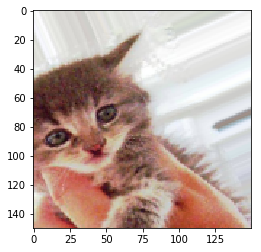

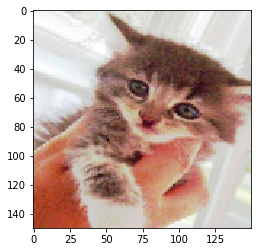

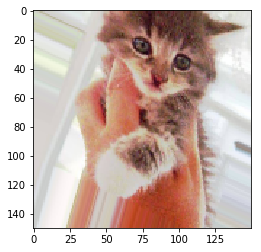

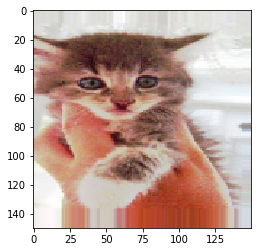

In [28]:
# Generate batches of randomly transformed images using the ImageGenerator
# Will loop indefinitely so need to break the loop at some point
i = 0    # counter variable

# The datagen will output images in batches of 1 image at a time
for batch in datagen.flow(x, batch_size=1):
    # Subplot identifier
    plt.figure(i)   
    
    # Add current data generator output to an image plot
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    
    # Increment the counter
    i += 1
    
    # If 4 batches i.e. 4 images generated, break the loop
    if i % 4 == 0:
        break

plt.show()

## Creating a Model

In [29]:
from tensorflow.keras import models, layers

In [31]:
# Insantiate
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Final convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten by dot product with convolutional kernal
model.add(layers.Flatten())

# Add a Dropout layer to further reduce overfitting
# Half of outputs of the Flattne layer will go to zero
# Prevents random associations in data from affecting performance
model.add(layers.Dropout(0.5))

# Densely connected classifier
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Compile

In [32]:
from tensorflow.keras.optimizers import RMSprop

In [33]:
model.compile(loss='binary_crossentropy', 
             optimizer=RMSprop(lr=1e-4), 
             metrics=['acc'])

## Augmenting Data for Training

In [34]:
# Training set will be augmented with random transformations
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [35]:
# Test set will not be augmented, only rescaled 
test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
# Define where the training data will come from
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32,
    class_mode='binary')

# Define where hte validation data willcome from
valiation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Fit the Model

- 100 steps or batches of the training generator per epoch
- 100 epochs
- so 10_000 batches to train the data. Compare this with the 30 batches that were drawn from the original data.
- The only reason we are able to do this is because we have configured the data generator to create 32 different variants of each image - effectively tripling the data set's size.
- More data used to train the model per epoch, which leads to less overfitting.
- Performance also improved by addition of a Dropout layer.

In [ ]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=100, 
    validation_data=validation_generator, 
    valibdation_steps=50)

## Save the Model

In [ ]:
model.save('cats_and_dogs_small_2.h5')

## Visualize Performance

In [ ]:
# Extract data from history object
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(val_acc) + 1)

In [ ]:
# Plotting Accuracy
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True);
plt.show();

In [ ]:
# Plotting Loss
plt.figure(); plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', legend='Validation Loss');
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); 
plt.grid(True); plt.show()